## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin
***

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import lasio
import pywt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import linalg, optimize
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
'''
Check if Torch is successfully built with GPU support
'''
torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
print('\n'+'-'*60)
print('----------------------- VERSION INFO -----------------------')
print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
print('# Device(s) available: {}, Name(s): {}'.format(count, name))
print('-'*60+'\n')


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [3]:
column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
index_name   = 'DEPTH'
# well 1
well1 = lasio.read('well1.las').df()
case1 = well1[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna() #['RV72H_1D','RH72H_1D']
case1.columns = column_names
case1.index.name = index_name
# well 2
well2 = lasio.read('well2.LAS').df()
case2 = well2[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()
case2.columns = column_names
case2.index.name = index_name

***

In [4]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

In [40]:
def plot_pinn_results(results, figsize=(12.5,12.5), height_ratios=[1, 0.3, 0.3],
                      gr_lim=[0,150], at_lim=[0.2,50], r_lim=[0.15,120], h_lim=[0.2,10],
                      csh_c='k', rss_c='k', bins=50, cmaps=['Reds','Blues']):

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 4, figure=fig, height_ratios=height_ratios)

    ax11 = fig.add_subplot(gs[0, 0]); ax11.set(ylabel='Depth [ft]')
    ax12 = fig.add_subplot(gs[0, 1])
    ax13 = fig.add_subplot(gs[0, 2])
    ax14 = fig.add_subplot(gs[0, 3])

    ax21 = fig.add_subplot(gs[1, 0])
    ax22 = fig.add_subplot(gs[1, 1])
    ax23 = fig.add_subplot(gs[1, 2])
    ax24 = fig.add_subplot(gs[1, 3])

    ax3 = fig.add_subplot(gs[2,:])

    ax11b = ax11.twiny()
    plot_curve(ax11, results, 'GR', gr_lim[0], gr_lim[1], 'g', units='API', pad=8)
    plot_curve(ax11b, results, 'Csh_pred', 0, 1, csh_c, units='v/v')

    ax12b, ax12c = ax12.twiny(), ax12.twiny()
    plot_curve(ax12, results, 'AT10', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax12b, results, 'AT90', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    plot_curve(ax12c, results, 'Rss_pred', at_lim[0], at_lim[1], rss_c, units='$\Omega\cdot m$', semilog=True)

    ax13b, ax13c = ax13.twiny(), ax13.twiny()
    plot_curve(ax13, results, 'Rv', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax13b, results, 'Rv_sim', at_lim[0], at_lim[1], 'k', units='$\Omega\cdot m$', semilog=True)
    plot_curve(ax13c, results, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax14b, ax14c = ax14.twiny(), ax14.twiny()
    plot_curve(ax14, results, 'Rh', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax14b, results, 'Rh_sim', at_lim[0], at_lim[1], 'k', units='$\Omega\cdot m$', semilog=True)
    plot_curve(ax14c, results, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in [ax11, ax12, ax13, ax14]]
    [ax.invert_yaxis() for ax in [ax11, ax12, ax13, ax14]]

    ax21.hist(results['Csh_pred'], bins=bins, color=csh_c, edgecolor='k', alpha=0.6, density=True)
    ax21.set(xlabel='Csh', ylabel='Density', xlim=(0,1))

    ax22.hist(results['Rss_pred'], bins=bins, color=rss_c, edgecolor='k', alpha=0.6, density=True)
    ax22.set(xlabel='Rss [$\Omega\cdot m$]', ylabel='Density')

    ax23.scatter(results['Rv'], results['Rv_sim'], c=results.index, cmap=cmaps[0], edgecolor='gray', alpha=0.6)
    ax23.set(xlabel='Rv true [$\Omega\cdot m$]', ylabel='Rv simulated [$\Omega\cdot m$]',
                xlim=r_lim, ylim=r_lim, xscale='log', yscale='log')
    ax23.plot(r_lim, r_lim, 'k--')

    ax24.scatter(results['Rh'], results['Rh_sim'], c=results.index, cmap=cmaps[1], edgecolor='gray', alpha=0.6)
    ax24.set(xlabel='Rh true [$\Omega\cdot m$]', ylabel='Rh simulated [$\Omega\cdot m$]',
                xlim=h_lim, ylim=h_lim, xscale='log', yscale='log')
    ax24.plot(h_lim, h_lim, 'k--')

    [ax.grid(True, which='both', alpha=0.4) for ax in [ax21, ax22, ax23, ax24, ax3]]

    ax3.plot(results.index, results['Rvsh'], c='darkred', label='Rvsh')
    ax3.plot(results.index, np.ones_like(results['Rvsh'])*results['Rvsh'].mean(), c='r', ls='--', label='Rvsh_mean')
    #ax3.text(10025, results['Rvsh'].mean()+2, 'Mean: {:.3f}'.format(results['Rvsh'].mean()), color='r', bbox=dict(facecolor='lightgrey'))
    ax3.plot(results.index, results['Rhsh'], c='darkblue', label='Rhsh')
    ax3.plot(results.index, np.ones_like(results['Rhsh'])*results['Rhsh'].mean(), c='b', ls='--', label='Rhsh_mean')
    #ax3.text(10025, results['Rhsh'].mean()+.5, 'Mean: {:.3f}'.format(results['Rhsh'].mean()), color='b', bbox=dict(facecolor='lightgrey'))
    ax3.legend(facecolor='lightgrey', edgecolor='k')
    ax3.set(yscale='log', xlabel='Depth [ft]', ylabel='Resistivity [$\Omega\cdot m$]')

    plt.tight_layout()
    plt.show()
    return None

In [6]:
def plot_pinn_gb_comparison(pinn_results, gb_results, figsize=(12.5,12.5), height_ratios=[1, 0.3],
                            gr_lim=[0,150], at_lim=[0.2,50], pinn_c='k', gb_c='gray', cmaps=['Greens', 'Oranges', 'Reds','Blues']):

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 4, figure=fig, height_ratios=height_ratios)

    ax11 = fig.add_subplot(gs[0, 0]); ax11.set(ylabel='Depth [ft]')
    ax12 = fig.add_subplot(gs[0, 1])
    ax13 = fig.add_subplot(gs[0, 2])
    ax14 = fig.add_subplot(gs[0, 3])

    ax21 = fig.add_subplot(gs[1, 0]); ax21.set(xlim=(0,1), ylim=(0,1), ylabel='Gradient-Based')
    ax22 = fig.add_subplot(gs[1, 1]); ax22.set(xlim=(0.2,80), ylim=(0.2,80))
    ax23 = fig.add_subplot(gs[1, 2])
    ax24 = fig.add_subplot(gs[1, 3])

    axs = [ax11, ax12, ax13, ax14, ax21, ax22, ax23, ax24]

    ax11b, ax11c = ax11.twiny(), ax11.twiny()
    plot_curve(ax11, pinn_results, 'GR', gr_lim[0], gr_lim[1], 'g', units='API')
    plot_curve(ax11b, gb_results, 'Csh_pred', 0, 1, gb_c, ls='--', units='v/v', pad=8)
    plot_curve(ax11c, pinn_results, 'Csh_pred', 0, 1, pinn_c, ls='--', units='v/v', pad=16)

    ax12b, ax12c, ax12d = ax12.twiny(), ax12.twiny(), ax12.twiny()
    plot_curve(ax12, pinn_results, 'AT10', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$')
    plot_curve(ax12b, pinn_results, 'AT90', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax12c, gb_results, 'Rss_pred', at_lim[0], at_lim[1], gb_c, semilog=True, units='$\Omega\cdot m$', pad=16)
    plot_curve(ax12d, pinn_results, 'Rss_pred', at_lim[0], at_lim[1], pinn_c, semilog=True, units='$\Omega\cdot m$', pad=24)

    ax13b, ax13c = ax13.twiny(), ax13.twiny()
    plot_curve(ax13, pinn_results, 'Rv', at_lim[0], at_lim[1], 'r', semilog=True, units='$\Omega\cdot m$')
    plot_curve(ax13b, gb_results, 'Rv_sim', at_lim[0], at_lim[1], gb_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax13c, pinn_results, 'Rv_sim', at_lim[0], at_lim[1], pinn_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

    ax14b, ax14c = ax14.twiny(), ax14.twiny()
    plot_curve(ax14, pinn_results, 'Rh', at_lim[0], at_lim[1], 'b', semilog=True, units='$\Omega\cdot m$')
    plot_curve(ax14b, gb_results, 'Rh_sim', at_lim[0], at_lim[1], gb_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax14c, pinn_results, 'Rh_sim', at_lim[0], at_lim[1], pinn_c, ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

    ax21.scatter(pinn_results['Csh_pred'], gb_results['Csh_pred'], c=pinn_results.index, cmap=cmaps[0], edgecolor='gray', alpha=0.6)
    ax22.scatter(pinn_results['Rss_pred'], gb_results['Rss_pred'], c=pinn_results.index, cmap=cmaps[1], edgecolor='gray', alpha=0.6)
    ax23.scatter(pinn_results['Rv_sim'], gb_results['Rv_sim'], c=pinn_results.index, cmap=cmaps[2], edgecolor='gray', alpha=0.6)
    ax24.scatter(pinn_results['Rh_sim'], gb_results['Rh_sim'], c=pinn_results.index, cmap=cmaps[3], edgecolor='gray', alpha=0.6)

    [ax.set(xscale='log') for ax in [ax12, ax13]]
    [ax.invert_yaxis() for ax in [ax11, ax12, ax13]]
    [ax.grid(True, which='both', alpha=0.4) for ax in axs]
    [ax.set(xlabel='PINN') for ax in axs[3:]]
    [ax.set(xscale='log', yscale='log') for ax in axs[-3:]]
    [ax.axline((0,0), (1,1), c='k', ls='--') for ax in axs[-3:]]

    plt.tight_layout()
    plt.show()
    return None

***

In [439]:
class ResInvPINN(nn.Module):
    def __init__(self):
        super(ResInvPINN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 4)

    def constraints(self, x):
        c, s, v, h = x[:, 0], x[:, 1], x[:, 2], x[:, 3]
        c = nn.Sigmoid()(c)
        v, h = nn.ELU()(v), nn.ELU()(h)
        return torch.stack([c, s, v, h], dim=-1)
       
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.constraints(x)
        return x
    
class ResInvLoss(nn.Module):
    def __init__(self, lambda_reg=1e-5, lambda_p=2):
        super(ResInvLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        Rvsh_pred = outputs[:, 2]
        Rhsh_pred = outputs[:, 3]

        eq1 = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs[:,[2,3]], p=self.lambda_p)

        return  costf + regPa

In [440]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())

data      = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]
res_aniso = data[['Rv', 'Rh']]

inputs = torch.tensor(res_aniso.values, dtype=torch.float32)
print('Inputs: {}'.format(inputs.shape))

Inputs: torch.Size([1560, 2])


X_train: 1326 | X_valid: 234
Epoch: 0 | Loss: 99.9697 | Valid Loss: 5.9581
Epoch: 100 | Loss: 2.2800 | Valid Loss: 2.9769
Epoch: 200 | Loss: 2.3560 | Valid Loss: 1.6726
Epoch: 300 | Loss: 1.6053 | Valid Loss: 0.9759


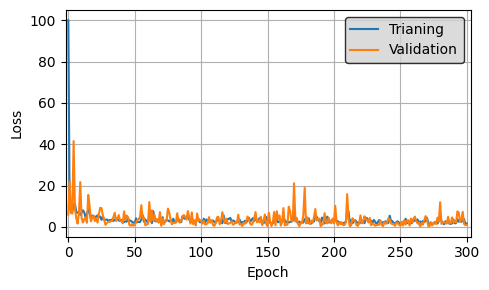

In [453]:
dataset        = TensorDataset(inputs)
train_percent  = 0.85
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

trainloader    = DataLoader(xtrain, batch_size=32, shuffle=True)
validloader    = DataLoader(xvalid, batch_size=32, shuffle=True)

pinn       = ResInvPINN()
criterion  = ResInvLoss(lambda_reg=1e-7, lambda_p=1)
optimizer  = torch.optim.Adam(params=pinn.parameters(), lr=1e-3)

epochs, monitor = 301, 100
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    pinn.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        y = pinn(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    pinn.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        y = pinn(x)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

plt.figure(figsize=(5,3))
plt.plot(range(epochs), train_loss, label='Trianing', c='tab:blue')
plt.plot(range(epochs), valid_loss, label='Validation', c='tab:orange')
plt.legend(facecolor='lightgrey', edgecolor='k')
plt.grid(True, which='both')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.xlim(-2, epochs+2)
plt.tight_layout()
plt.show()

Csh: min=0.955 | max=1.000


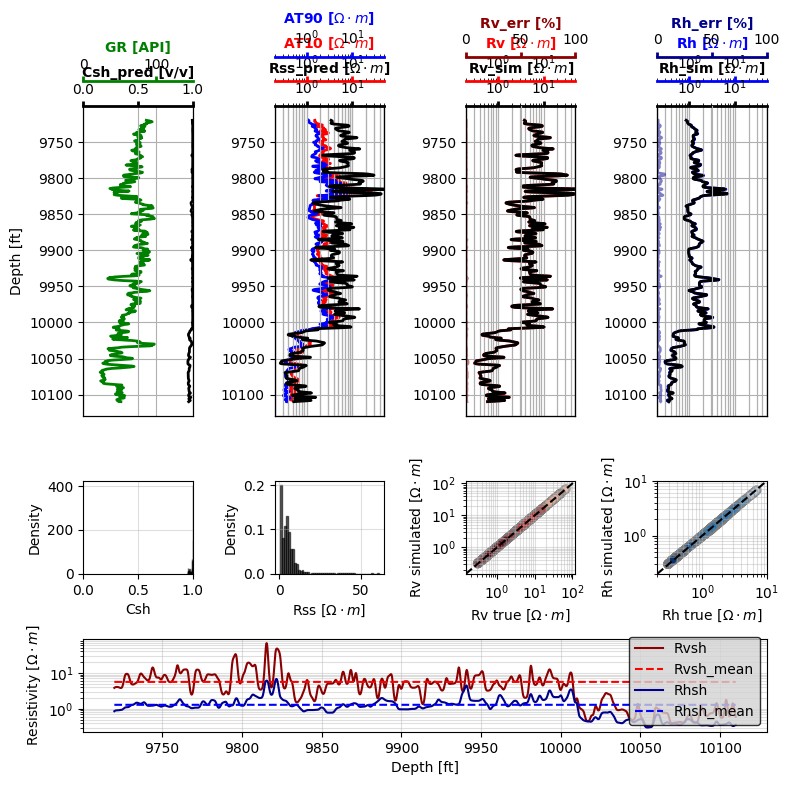

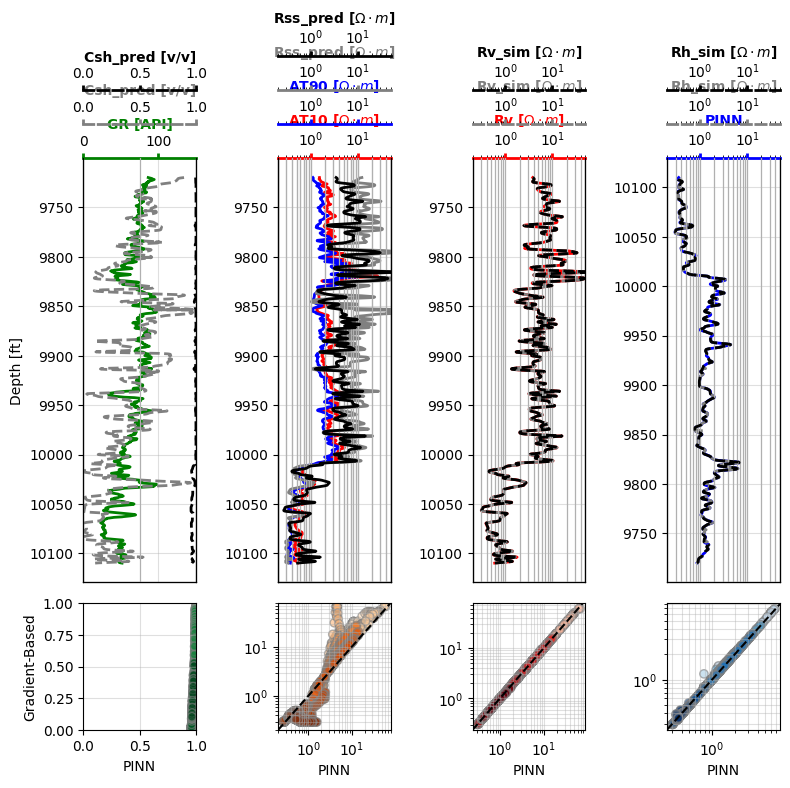

In [454]:
y_pred = pinn(inputs[:,:2]).detach().numpy().squeeze()
Csh_pred, Rss_pred, Rvsh_pred, Rhsh_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh: min={:.3f} | max={:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values

Rv_sim = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred)

Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred, 
                         'Rvsh':Rvsh_pred, 'Rhsh':Rhsh_pred,
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, pinn_sol], axis=1)
results.to_csv('pinn_solution.csv', index=True)

plot_pinn_results(results, figsize=(8,8))
gradientbased_results = pd.read_csv('gradient_based_solution.csv', index_col=0)
plot_pinn_gb_comparison(results, gradientbased_results, figsize=(8,8))

***
# END